Exercise Sheet 6.2 **Long short-term memory (LSTM)**

In [ ]:
import numpy as np
from keras import Sequential
from keras.callbacks import Callback
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt


In [2]:
class LogHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []

    def on_batch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))


In [3]:
def input_maker():
    # input data and labels setup as a natural selection
    input_data = np.random.randint(low=0, high=10, size=(10000, 1, 30))
    true_labels = np.array([np.sum(input_data, axis=2) >= 100]).astype(int)[0, :, 0].T

    # slicing for training and validation
    training_input = input_data[0:8000, :, :]
    validation_input = input_data[8000:, :, :]
    training_labels = true_labels[0:8000]
    validation_labels = true_labels[8000:]

    # checking the ratios
    i_number_of_ones = np.count_nonzero(true_labels)
    print('Number of series which add up to 100 or more = %d' % i_number_of_ones)
    i_number_of_zeros = len(true_labels) - i_number_of_ones
    print('Number of series which add up to less than 100 = %d' % i_number_of_zeros)
    i_ratio = i_number_of_ones / i_number_of_zeros
    print('the ratio of ones to zeroes in the labels = %d' % int(i_ratio))

    return training_input, validation_input, training_labels, validation_labels


In [4]:

def input_maker_rnd():
    # a bad implementation of random selection of series
    input_data = np.zeros((10000, 1, 30))
    i = 0
    while i < 5000:
        temp_array = np.random.randint(low=0, high=10, size=(1, 1, 30))
        if np.sum(temp_array) >= 100:
            input_data[i,0,:] = temp_array
            i+=1
    while i < 10000:
        temp_array = np.random.randint(low=0, high=10, size=(1, 1, 30))
        if np.sum(temp_array) < 100:
            input_data[i,0,:] = temp_array
            i+=1
    np.random.shuffle(input_data)

    # true labels
    true_labels = np.array([np.sum(input_data, axis=2) >= 100]).astype(int)[0,:,0].T

    # checking the ratios
    i_number_of_ones = np.count_nonzero(true_labels)
    print('Number of series which add up to 100 or more = %d' % i_number_of_ones)
    i_number_of_zeros = len(true_labels) - i_number_of_ones
    print('Number of series which add up to less than 100 = %d' % i_number_of_zeros)
    i_ratio = i_number_of_ones / i_number_of_zeros
    print('the ratio of ones to zeroes in the labels = %d' % int(i_ratio))

    # slicing for training and validation
    training_input = input_data[0:8000, :, :]
    validation_input = input_data[8000:, :, :]
    training_labels = true_labels[0:8000]
    validation_labels = true_labels[8000:]

    return training_input, validation_input, training_labels, validation_labels


In [5]:
# creating the random inputs
training_input, validation_input, training_labels, validation_labels = input_maker()


Number of series which add up to 100 or more = 9874
Number of series which add up to less than 100 = 126
the ratio of ones to zeroes in the labels = 78


In [6]:
# defining the model
model = Sequential()

model.add(layers.LSTM(units=200,
                      activation='tanh',
                      recurrent_activation='hard_sigmoid',
                      use_bias=True,
                      unit_forget_bias=True))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))


In [7]:
# call back function
log_history = LogHistory()

# the adam optimizer
adam = optimizers.Adam(lr=0.001,
                       beta_1=0.9,
                       beta_2=0.999,
                       epsilon=1e-8)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['binary_accuracy'])

training_log = model.fit(training_input,
                         training_labels,
                         batch_size=50,
                         epochs=60,
                         shuffle=True,
                         validation_data=(validation_input, validation_labels),
                         callbacks=[log_history])


Train on 8000 samples, validate on 2000 samples
Epoch 1/60
8000/8000 [==============================] - 4s 510us/step - loss: 0.0651 - binary_accuracy: 0.9868 - val_loss: 0.0573 - val_binary_accuracy: 0.9860
Epoch 2/60
8000/8000 [==============================] - 2s 222us/step - loss: 0.0488 - binary_accuracy: 0.9878 - val_loss: 0.0584 - val_binary_accuracy: 0.9860
Epoch 3/60
8000/8000 [==============================] - 2s 245us/step - loss: 0.0446 - binary_accuracy: 0.9878 - val_loss: 0.0515 - val_binary_accuracy: 0.9860
Epoch 4/60
8000/8000 [==============================] - 2s 275us/step - loss: 0.0402 - binary_accuracy: 0.9880 - val_loss: 0.0506 - val_binary_accuracy: 0.9860
Epoch 5/60
8000/8000 [==============================] - 2s 229us/step - loss: 0.0372 - binary_accuracy: 0.9880 - val_loss: 0.0477 - val_binary_accuracy: 0.9860
Epoch 6/60
8000/8000 [==============================] - 2s 290us/step - loss: 0.0356 - binary_accuracy: 0.9884 - val_loss: 0.0463 - val_binary_accuracy:

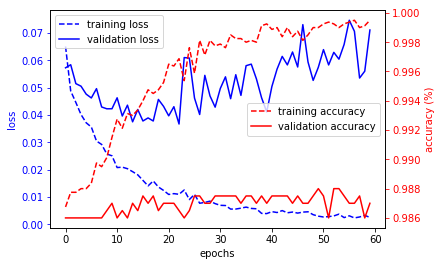

In [9]:
# plotting history for every batch
fig, ax1 = plt.subplots()
ax1.plot(training_log.history['loss'], '--', color='b', label='training loss')
ax1.plot(training_log.history['val_loss'], color='b', label='validation loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(training_log.history['binary_accuracy'], '--', color='r', label='training accuracy')
ax2.plot(training_log.history['val_binary_accuracy'], color='r', label='validation accuracy')
ax2.set_ylabel('accuracy (%)', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='center right')
plt.show()


The distribution has skew in the sample distribution (specifically, toward the majority class/class 1 where the sum of 30 digits being >= 100). So, when the network learns, it considers the majority class more heavily than the minority class/class 0(series sum < 100), and adjusts accordingly. If we view class 1 as positive and class 0 as negative, it will have higher sensitivty than specificity. The network could learn to only output class 1 and it would still very high accuracy results! So, we could say the network isn't discriminiative. Rather, its accuracy is a measure of the underlying class distribution.

To prove this we could compare accuracy of the network on each individual class. Surely, the accuracy for the majority class will be better than that of the minority class. 

As a solution to this we could create synthetic examples (made by duplicating or tranforming data in the minority class) to match the number of examples majority class, thus oversampling the minority class. Or, we could undersample the majority class, and train the network on all *n* series in the minority class and only *n* series from the majority class, taken at random.

This question has made us consider a very common problem in deep learning: the problem of *imbalanced data*.